In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Load data

In [348]:
import requests
from zipfile import ZipFile
from io import BytesIO

## load the big loan data
loan_data_path = [f"https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_{i}.csv.zip" for i in range(3)]
rs = [requests.get(path) for path in loan_data_path]
files = [ZipFile(BytesIO(r.content)) for r in rs]
loan_data = []
i = 0 
for f in files:
    loan_data.append(pd.read_csv(f.open(f"kiva_loans_part_{i}.csv")))
    i += 1

## concat all parts of kiva_loan_data
df = pd.concat(loan_data)

In [349]:
#changing datatype
df['year']=pd.to_datetime(df['date']).dt.year.astype(str)

In [350]:
columns=['id',
          'loan_amount',
            'activity',
              'sector',
                'country',
                  'region',
                    'term_in_months',
                      'borrower_genders',
                        'repayment_interval',
                          'year']

In [351]:
df=df[columns]

In [352]:
df.head()

,id,loan_amount,activity,sector,country,region,term_in_months,borrower_genders,repayment_interval,year
0,653051,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,12.0,female,irregular,2014
1,653053,575.0,Rickshaw,Transportation,Pakistan,Lahore,11.0,"female, female",irregular,2014
2,653068,150.0,Transportation,Transportation,India,Maynaguri,43.0,female,bullet,2014
3,653063,200.0,Embroidery,Arts,Pakistan,Lahore,11.0,female,irregular,2014
4,653084,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,14.0,female,monthly,2014


Loading mpi data

In [353]:
mpi=pd.read_csv('mpi_by_country.csv')
mpi.rename(columns={'Country': 'country'}, inplace=True)
df_merged = df.merge(mpi[['country', 'MPI']], on='country', how='left')
df_merged = df_merged.dropna(subset=['MPI'])

#checking how many NaN values
nan_count_per_column = df_merged.isna().sum()
print(nan_count_per_column)

id                        0
loan_amount               0
activity                  0
sector                    0
country                   0
region                46509
term_in_months            0
borrower_genders       3909
repayment_interval        0
year                      0
MPI                       0
dtype: int64


In [374]:
df_merged = df_merged.dropna(subset=['region'])

# again how many NaN values
nan_count_per_column = df_merged.isna().sum()
print(nan_count_per_column)

id                    0
loan_amount           0
activity              0
sector                0
country               0
region                0
term_in_months        0
borrower_genders      0
repayment_interval    0
year                  0
MPI                   0
dtype: int64


In [355]:
df_merged.shape

(582385, 11)

In [356]:
df_merged.head(10)

,id,loan_amount,activity,sector,country,region,term_in_months,borrower_genders,repayment_interval,year,MPI
0,653051,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,12.0,female,irregular,2014,0.230
1,653053,575.0,Rickshaw,Transportation,Pakistan,Lahore,11.0,"female, female",irregular,2014,0.230
2,653068,150.0,Transportation,Transportation,India,Maynaguri,43.0,female,bullet,2014,0.191
3,653063,200.0,Embroidery,Arts,Pakistan,Lahore,11.0,female,irregular,2014,0.230
4,653084,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,14.0,female,monthly,2014,0.230
6,653067,200.0,Dairy,Agriculture,India,Maynaguri,43.0,female,bullet,2014,0.191
7,653078,400.0,Beauty Salon,Services,Pakistan,Ellahabad,14.0,female,monthly,2014,0.230
8,653082,475.0,Manufacturing,Manufacturing,Pakistan,Lahore,14.0,female,monthly,2014,0.230
9,653048,625.0,Food Production/Sales,Food,Pakistan,Lahore,11.0,female,irregular,2014,0.230
10,653060,200.0,Rickshaw,Transportation,Pakistan,Lahore,11.0,female,irregular,2014,0.230


In [357]:
df_merged = df_merged.reset_index(drop=True)

One-hot encoder & LabelEncoder

In [375]:
#One-hot encoder for 'borrower_genders' and 'repayment_interval'

# borrower_gender
def replace_gender_values(value):
    if 'f' in value.lower():
        return 'female'
    else:
        return 'male'

df_merged['borrower_genders'] = df_merged['borrower_genders'].apply(replace_gender_values)

encoded_borrower_genders = pd.get_dummies(df_merged['borrower_genders'], prefix='gender').astype(float)

# repayment_interval

encoded_repayment_interval = pd.get_dummies(df_merged['repayment_interval'], prefix='repayment').astype(float)

# Append the encoded data to the original dataframe and drop the original 'borrower_genders' and 'repayment_interval' columns
df_merged_encoded = pd.concat([df_merged, encoded_repayment_interval, encoded_borrower_genders], axis=1).drop(['borrower_genders', 'repayment_interval'], axis=1)

df_merged_encoded.head(5)

,id,loan_amount,activity,sector,country,region,term_in_months,year,MPI,repayment_bullet,repayment_irregular,repayment_monthly,gender_female,gender_male
0,653051,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,12.0,2014,0.230,0.0,1.0,0.0,1.0,0.0
1,653053,575.0,Rickshaw,Transportation,Pakistan,Lahore,11.0,2014,0.230,0.0,1.0,0.0,1.0,0.0
2,653068,150.0,Transportation,Transportation,India,Maynaguri,43.0,2014,0.191,1.0,0.0,0.0,1.0,0.0
3,653063,200.0,Embroidery,Arts,Pakistan,Lahore,11.0,2014,0.230,0.0,1.0,0.0,1.0,0.0
4,653084,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,14.0,2014,0.230,0.0,0.0,1.0,1.0,0.0


In [376]:
#Label sector 
from sklearn.preprocessing import LabelEncoder
label_sector = LabelEncoder()
#Transforming the 'sector' column using LabelEncoder
df_merged_encoded['sector_encoded'] = label_sector.fit_transform(df_merged['sector'])
display(df_merged_encoded[['sector', 'sector_encoded']].head())


,sector,sector_encoded
0,Food,6
1,Transportation,13
2,Transportation,13
3,Arts,1
4,Food,6


In [377]:
df_merged_encoded.columns

Index(['id', 'loan_amount', 'activity', 'sector', 'country', 'region',
       'term_in_months', 'year', 'MPI', 'repayment_bullet',
       'repayment_irregular', 'repayment_monthly', 'gender_female',
       'gender_male', 'sector_encoded'],
      dtype='object')

In [378]:
std_scaler=StandardScaler()
x=df_merged_encoded[['loan_amount','sector_encoded','term_in_months','year','MPI','repayment_bullet',
       'repayment_irregular', 'repayment_monthly', 'gender_female',
       'gender_male',]]
x_scaled=std_scaler.fit_transform(x)

Conducting PCA

In [379]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

In [380]:
x_pca.shape

(582385, 2)

K-MEANS

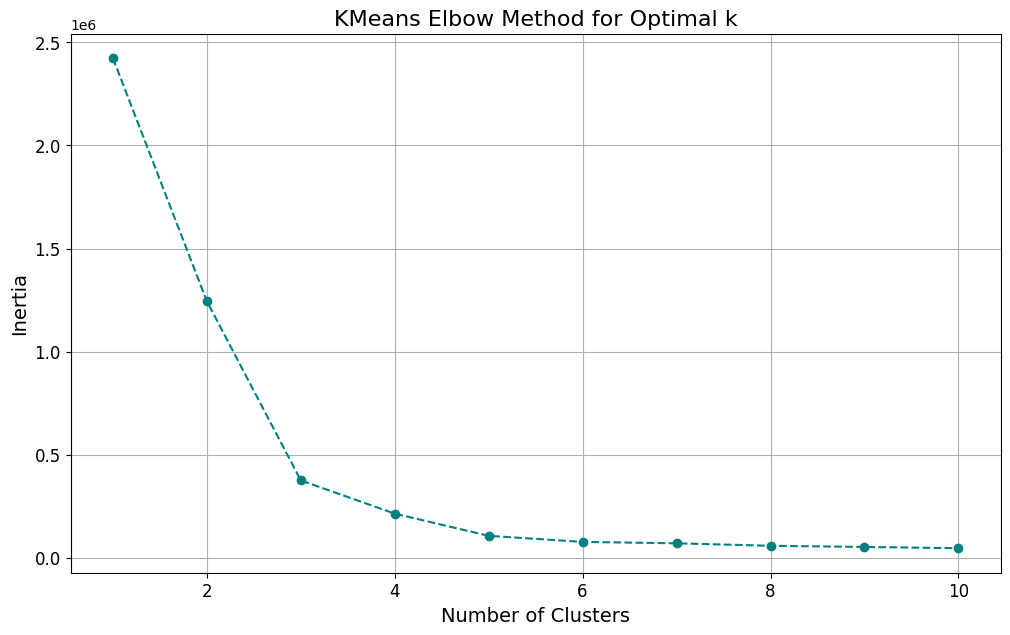

In [364]:
# Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
clusters = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_pca)  
    clusters.append(kmeans.inertia_)
plt.figure(figsize=(12, 7))
plt.plot(range(1, 11), clusters, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('KMeans Elbow Method for Optimal k', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


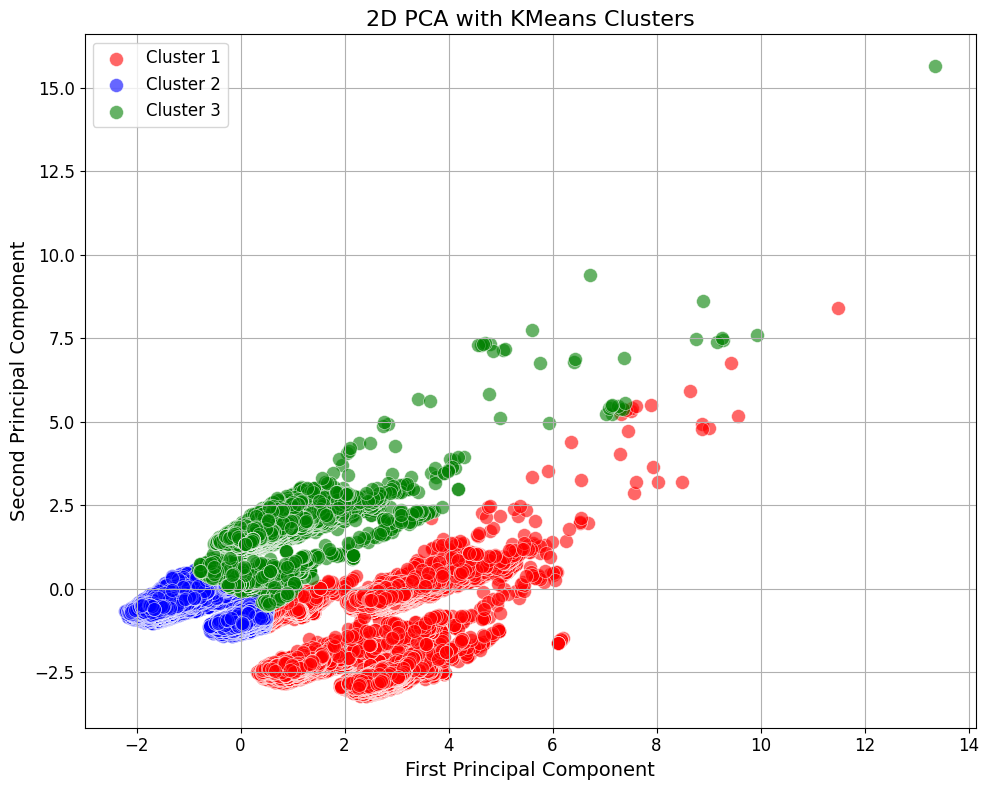

In [381]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#  Conducting KMeans clustering (assuming 3 clusters from the elbow method)
kmeans = KMeans(n_clusters=3, random_state=0).fit(x_pca)
labels = kmeans.labels_
# Visualizing clusters
colors = ['red', 'blue', 'green']
plt.figure(figsize=(10, 8))
for i, color, label in zip(range(3), colors, ['Cluster 1', 'Cluster 2', 'Cluster 3']):
    plt.scatter(x_pca[labels == i, 0], x_pca[labels == i, 1], 
                s=100, c=color, label=label, alpha=0.6, edgecolors='w', linewidth=0.5)
    
plt.legend(fontsize=12)
plt.title('2D PCA with KMeans Clusters', fontsize=16)
plt.xlabel('First Principal Component', fontsize=14)
plt.ylabel('Second Principal Component', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Analyzing clusters 

In [382]:
# Adding new column 'cluster' to our data
df_merged_encoded['cluster'] = labels
df_merged_encoded.head(5)


,id,loan_amount,activity,sector,country,region,term_in_months,year,MPI,repayment_bullet,repayment_irregular,repayment_monthly,gender_female,gender_male,sector_encoded,cluster
0,653051,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,12.0,2014,0.230,0.0,1.0,0.0,1.0,0.0,6,1
1,653053,575.0,Rickshaw,Transportation,Pakistan,Lahore,11.0,2014,0.230,0.0,1.0,0.0,1.0,0.0,13,1
2,653068,150.0,Transportation,Transportation,India,Maynaguri,43.0,2014,0.191,1.0,0.0,0.0,1.0,0.0,13,0
3,653063,200.0,Embroidery,Arts,Pakistan,Lahore,11.0,2014,0.230,0.0,1.0,0.0,1.0,0.0,1,1
4,653084,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,14.0,2014,0.230,0.0,0.0,1.0,1.0,0.0,6,2


In [367]:
df_merged_encoded.groupby('cluster')[['loan_amount','term_in_months','MPI']].mean()

,loan_amount,term_in_months,MPI
cluster,,,
0,826.070535,17.790504,0.139726
1,561.113843,10.277077,0.105814
2,872.970559,15.013010,0.136203


In [368]:
# repayment_interval
repayment_cols = ['repayment_bullet', 'repayment_irregular', 'repayment_monthly']
repayment_distribution = df_merged_encoded.groupby('cluster')[repayment_cols].sum()
display(repayment_distribution)

,repayment_bullet,repayment_irregular,repayment_monthly
cluster,,,
0,36592.0,15969.0,74525.0
1,27385.0,211549.0,0.0
2,119.0,1366.0,214880.0


In [369]:
# Distribution of sectors within clusters (sorted by the number of loans)
sector_distribution = df_merged_encoded.groupby(['sector', 'cluster']).size().unstack()
sector_totals = sector_distribution.sum(axis=1)
sector_distribution_sorted = sector_distribution.loc[sector_totals.sort_values(ascending=False).index]
display(sector_distribution_sorted)

cluster,0,1,2
sector,,,
Agriculture,49524,53979,61152
Food,13238,67133,36416
Retail,12757,68429,28360
Services,8262,10991,16369
Personal Use,8349,4393,22286
Housing,6969,8021,12598
Clothing,2502,10987,12750
Education,10017,2330,11178
Transportation,6341,4609,3242


In [370]:
# Gender distribution within clusters
gender_cols = ['gender_female', 'gender_male']
gender_distribution = df_merged_encoded.groupby('cluster')[gender_cols].sum()
gender_totals = gender_distribution.sum(axis=1)
gender_distribution_sorted = gender_distribution.loc[gender_totals.sort_values(ascending=False).index]
display(gender_distribution_sorted)

,gender_female,gender_male
cluster,,
1,238934.0,0.0
2,216351.0,14.0
0,9101.0,117985.0


Recomendation


This system recommends the top 5 loans that are the most similar to a given loan based on cosine similarity and returns key details about those loans.



In [383]:
df_merged_encoded

,id,loan_amount,activity,sector,country,region,term_in_months,year,MPI,repayment_bullet,repayment_irregular,repayment_monthly,gender_female,gender_male,sector_encoded,cluster
0,653051,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,12.0,2014,0.230,0.0,1.0,0.0,1.0,0.0,6,1
1,653053,575.0,Rickshaw,Transportation,Pakistan,Lahore,11.0,2014,0.230,0.0,1.0,0.0,1.0,0.0,13,1
2,653068,150.0,Transportation,Transportation,India,Maynaguri,43.0,2014,0.191,1.0,0.0,0.0,1.0,0.0,13,0
3,653063,200.0,Embroidery,Arts,Pakistan,Lahore,11.0,2014,0.230,0.0,1.0,0.0,1.0,0.0,1,1
4,653084,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,14.0,2014,0.230,0.0,0.0,1.0,1.0,0.0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582380,1340328,875.0,Livestock,Agriculture,Bolivia,La Paz,13.0,2017,0.089,0.0,0.0,1.0,1.0,0.0,0,2
582381,1340333,125.0,Livestock,Agriculture,Mexico,Iztacalco,13.0,2017,0.005,0.0,0.0,1.0,1.0,0.0,0,2
582382,1340329,50.0,Livestock,Agriculture,Ghana,Dansoman,13.0,2017,0.156,0.0,0.0,1.0,1.0,0.0,0,2
582383,1340325,250.0,Livestock,Agriculture,Ghana,Dansoman,13.0,2017,0.156,0.0,0.0,1.0,1.0,0.0,0,2


The code implements a recommendation system based on cosine similarity, using Principal Component Analysis (PCA) results

In [384]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_recommendation_pca(loan_id, x_pca, df_merged_encoded, top_n=5):
    
    loan_index = df_merged_encoded[df_merged_encoded['id'] == loan_id].index
    if loan_index.empty:
        return "Loan ID not found."
    
    df_merged_encoded['similarity'] = cosine_similarity(x_pca[loan_index], x_pca).flatten()
    
    similar_loans = df_merged_encoded[df_merged_encoded['id'] != loan_id].sort_values(by='similarity', ascending=False).head(top_n)
    
    return similar_loans[['id', 'loan_amount', 'sector', 'activity', 'gender_female', 'gender_male', 'country', 'similarity', 'repayment_bullet', 'repayment_irregular', 'repayment_monthly']]



In [385]:
loan_id = 653063
similar_loans = cosine_similarity_recommendation_pca(loan_id, x_pca=x_pca, df_merged_encoded=df_merged_encoded, top_n=5)
display(similar_loans)

,id,loan_amount,sector,activity,gender_female,gender_male,country,similarity,repayment_bullet,repayment_irregular,repayment_monthly
16161,671755,200.0,Arts,Embroidery,1.0,0.0,Pakistan,1.0,0.0,1.0,0.0
15613,671067,325.0,Agriculture,Dairy,1.0,0.0,Mali,1.0,0.0,1.0,0.0
20268,676781,625.0,Agriculture,Dairy,1.0,0.0,Vietnam,1.0,0.0,1.0,0.0
52089,713266,425.0,Agriculture,Livestock,1.0,0.0,Philippines,1.0,0.0,1.0,0.0
104749,777126,500.0,Agriculture,Agriculture,1.0,0.0,Burkina Faso,1.0,0.0,1.0,0.0
